INFO:tensorflow:Restoring parameters from D:/Code/AI city/SSD/SSD-Tensorflow-master/checkpoints/model.ckpt-54567
11000
11001
11002
11003
11004
11005
11006
11007


KeyboardInterrupt: 

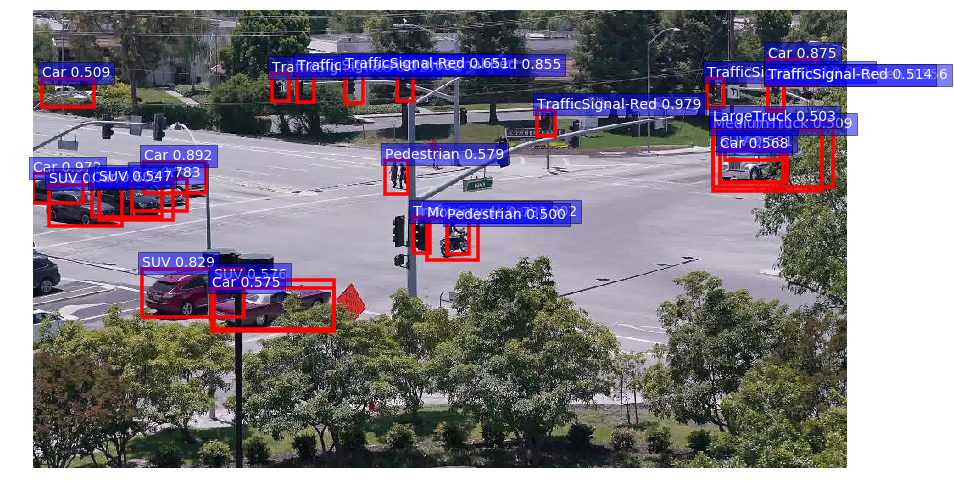

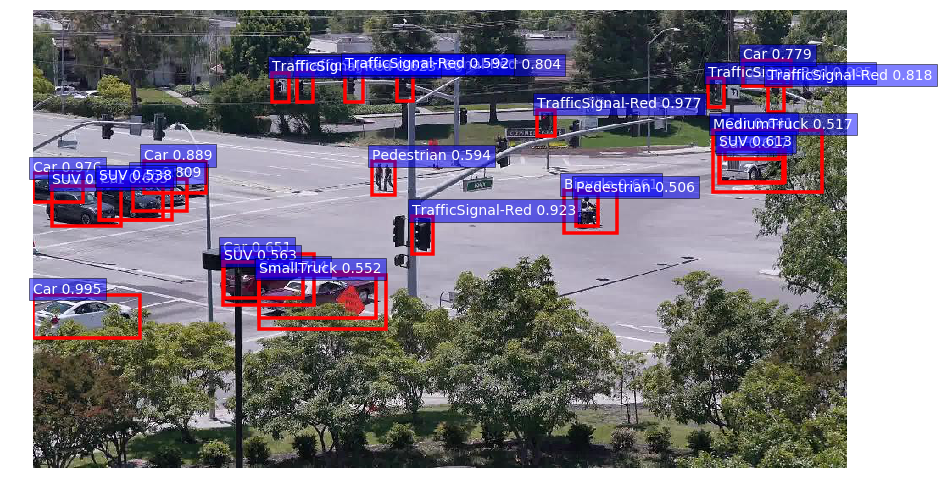

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


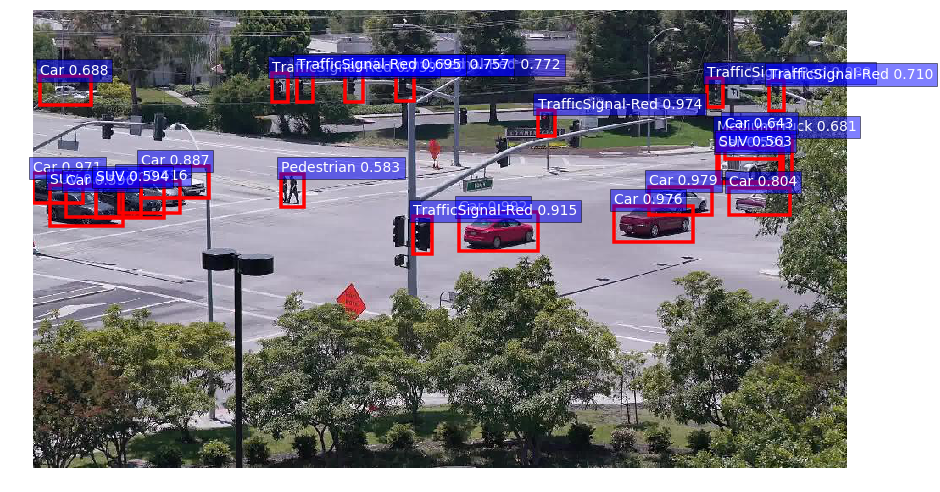

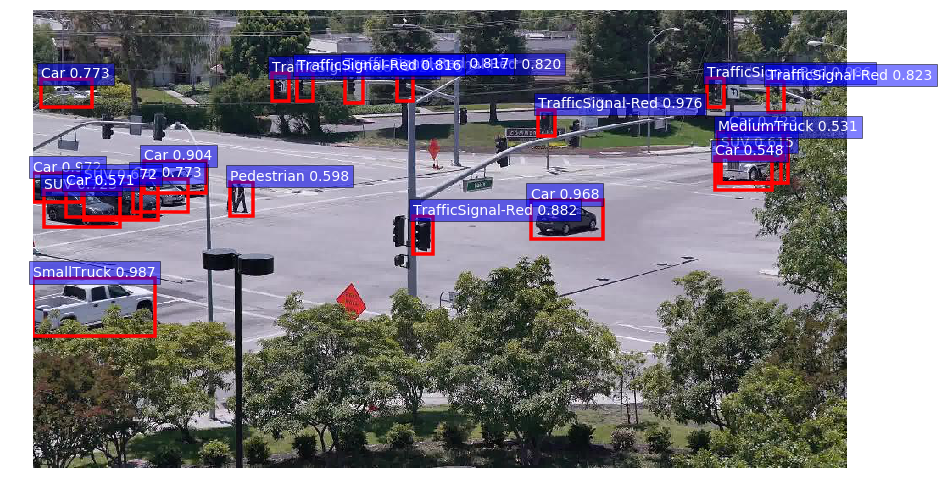

In [2]:
import os
import math
import random

import numpy as np
import tensorflow as tf
import cv2

slim = tf.contrib.slim



get_ipython().magic('matplotlib inline')
#%matplotlib inline

#import matplotlib
#matplotlib.use('Agg')

import matplotlib.pyplot as plt
import matplotlib.image as mpimg




import sys
sys.path.append('../')




from nets import ssd_vgg_512, ssd_common, np_methods
from preprocessing import ssd_vgg_preprocessing
#from notebooks import visualization





# TensorFlow session: grow memory when needed. TF, DO NOT USE ALL MY GPU MEMORY!!!
gpu_options = tf.GPUOptions(allow_growth=True)
config = tf.ConfigProto(log_device_placement=False, gpu_options=gpu_options)
isess = tf.InteractiveSession(config=config)




# Input placeholder.
net_shape = (512, 512)
data_format = 'NHWC'
img_input = tf.placeholder(tf.uint8, shape=(None, None, 3))
# Evaluation pre-processing: resize to SSD net shape.
image_pre, labels_pre, bboxes_pre, bbox_img = ssd_vgg_preprocessing.preprocess_for_eval(
    img_input, None, None, net_shape, data_format, resize=ssd_vgg_preprocessing.Resize.WARP_RESIZE)
image_4d = tf.expand_dims(image_pre, 0)

# Define the SSD model.
reuse = True if 'ssd_net' in locals() else None
ssd_net = ssd_vgg_512.SSDNet()
with slim.arg_scope(ssd_net.arg_scope(data_format=data_format)):
    predictions, localisations, _, _ = ssd_net.net(image_4d, is_training=False, reuse=reuse)

# Restore SSD model.
ckpt_filename = 'D:/Code/AI city/SSD/SSD-Tensorflow-master/checkpoints/model.ckpt-54567'
#ckpt_filename = '/workspace/SSD-Tensorflow/logs/model.ckpt-6021'
# ckpt_filename = '../checkpoints/VGG_VOC0712_SSD_300x300_ft_iter_120000.ckpt'
isess.run(tf.global_variables_initializer())
saver = tf.train.Saver()
saver.restore(isess, ckpt_filename)

# SSD default anchor boxes.
ssd_anchors = ssd_net.anchors(net_shape)


# In[ ]:


# Main image processing routine.
def process_image(img, select_threshold=0.5, nms_threshold=.45, net_shape=(512, 512)):
    # Run SSD network.
    rimg, rpredictions, rlocalisations, rbbox_img = isess.run([image_4d, predictions, localisations, bbox_img],
                                                              feed_dict={img_input: img})
    
    # Get classes and bboxes from the net outputs.
    rclasses, rscores, rbboxes = np_methods.ssd_bboxes_select(
            rpredictions, rlocalisations, ssd_anchors,
            select_threshold=select_threshold, img_shape=net_shape, num_classes=15, decode=True)
    
    rbboxes = np_methods.bboxes_clip(rbbox_img, rbboxes)
    rclasses, rscores, rbboxes = np_methods.bboxes_sort(rclasses, rscores, rbboxes, top_k=400)
    rclasses, rscores, rbboxes = np_methods.bboxes_nms(rclasses, rscores, rbboxes, nms_threshold=nms_threshold)
    # Resize bboxes to original image shape. Note: useless for Resize.WARP!
    rbboxes = np_methods.bboxes_resize(rbbox_img, rbboxes)
    return rclasses, rscores, rbboxes


def get_overlap(bbox1,bbox2,img_shape):
    im1 = np.zeros((img_shape[0],img_shape[1]))
    im2 = np.zeros((img_shape[0],img_shape[1]))
    im1[int(bbox1[1]):int(bbox1[3]),int(bbox1[0]):int(bbox1[2])] = 1
    im2[int(bbox2[1]):int(bbox2[3]),int(bbox2[0]):int(bbox2[2])] = 1
    im3 = im1+im2
    index = np.where(im3==2)
    overlap_area = index[0].shape[0]
    area1 = (bbox1[2]-bbox1[0])*(bbox1[3]-bbox1[1])
    area2 = (bbox2[2]-bbox2[0])*(bbox2[3]-bbox2[1])
    overlap_ratio = max(overlap_area/area1, overlap_area/area2)
    return overlap_ratio

# In[ ]:


def vis_detections(im, rclasses, rscores, rbboxes, class_set, thresh=0.5):
    im = im[:, :, (0, 1, 2)]
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.imshow(im, aspect='equal')
    for i in range(rbboxes.shape[0]):
        #import pdb; pdb.set_trace()
        bbox = np.zeros(4) 
        bbox[0] = rbboxes[i, 1]*im.shape[1]
        bbox[1] = rbboxes[i, 0]*im.shape[0]
        bbox[2] = rbboxes[i, 3]*im.shape[1]
        bbox[3] = rbboxes[i, 2]*im.shape[0]
        score = rscores[i]
        #import pdb; pdb.set_trace()
        ax.add_patch(
            plt.Rectangle((bbox[0], bbox[1]),
                          bbox[2] - bbox[0],
                          bbox[3] - bbox[1], fill=False,
                          edgecolor='red', linewidth=3.5)
            )
        ax.text(bbox[0], bbox[1] - 2,
                '{:s} {:.3f}'.format(class_set[str(rclasses[i])], score),
                bbox=dict(facecolor='blue', alpha=0.5),
                fontsize=14, color='white')

    #ax.set_title(('{} detections with '
    #              'p({} | box) >= {:.1f}').format(rclasses[], class_name,
    #                                              thresh),
    #              fontsize=14)
    plt.axis('off')
    plt.tight_layout()
    plt.savefig('a.jpg')
    img2 = mpimg.imread('a.jpg')
    #img2 = img2[:, :, (2, 1, 0)]
    #plt.imshow(img2)
    cv2.imshow('image',img2[:, :, (2, 1, 0)])
    cv2.waitKey(1)
    #plt.show()


# In[ ]:

class_set = {'0':'background', '1':'Car', '2':'SUV', '3':'SmallTruck', '4':'MediumTruck','5':'LargeTruck', 
             '6':'Pedestrian', '7':'Bus', '8':'Van', '9':'GroupOfPeople',
                         '10':'Bicycle', '11':'Motorcycle', '12':'TrafficSignal-Green', '13':'TrafficSignal-Yellow',
                         '14':'TrafficSignal-Red'}


# Test on some demo image and visualize output.
#path = 'F:/Vdo2Img/data/outputImg/' #'traffic_pic/'
path = 'D:/Code/AI city/aic_540/540_test_imgs/'
output_dir = 'D:/Code/AI city/aic_540/540_test_imgs/output/'
image_names = sorted(os.listdir(path))
dim = 540
for nn in range(0,len(image_names)):
    img_idx = nn
    img_path = path+image_names[img_idx]
#img_path = '/datasets/aic540-voc/JPEGImages/walsh_santomas_20170602_006_00138.jpeg'
#img_path = '/home/aic/traffic1.jpeg'
    
    img = mpimg.imread(img_path)
    img_shape = img.shape
    select_thresh = 0.5
    overlap_thresh = 0.5
    rclasses, rscores, rbboxes =  process_image(img, select_thresh, 0.25)

    num_cand = len(rscores)
    cand_idx = np.ones(num_cand)
    for n in range(num_cand):
        for m in range(n+1,num_cand):
            if cand_idx[n]==0 or cand_idx[m]==0:
                continue
            
            bbox1 = np.zeros(4)
            bbox1[0] = rbboxes[n, 1]*img_shape[1]
            bbox1[1] = rbboxes[n, 0]*img_shape[0]
            bbox1[2] = rbboxes[n, 3]*img_shape[1]
            bbox1[3] = rbboxes[n, 2]*img_shape[0]
            
            bbox2 = np.zeros(4)
            bbox2[0] = rbboxes[m, 1]*img_shape[1]
            bbox2[1] = rbboxes[m, 0]*img_shape[0]
            bbox2[2] = rbboxes[m, 3]*img_shape[1]
            bbox2[3] = rbboxes[m, 2]*img_shape[0]
            
            overlap_ratio = get_overlap(bbox1,bbox2,img_shape)
            if overlap_ratio>overlap_thresh:
                if rscores[n]>rscores[m]:
                    cand_idx[m] = 0
                else:
                    cand_idx[n] = 0
    
    remove_idx = np.where(cand_idx==0)
    new_classes = np.delete(rclasses, remove_idx)
    new_scores = np.delete(rscores, remove_idx)
    new_bboxes = np.delete(rbboxes, remove_idx, 0)
    
    for k in range(new_classes.shape[0]):
        
        if image_names[nn][0:3]=='san':
            
            if new_scores[k]<=0.6:
                continue
             
            #print(new_classes[k])
            #import pdb; pdb.set_trace()
            if new_bboxes[k][1]<dim/3 and (class_set[str(new_classes[k])]!='TrafficSignal-Green' and class_set[str(new_classes[k])]!='TrafficSignal-Yellow' and class_set[str(new_classes[k])]!='TrafficSignal-Red'):
                continue
        
        if image_names[nn][0:3]=='ste':
            #import pdb; pdb.set_trace()
            if new_bboxes[k][3]>=dim/10*9 and new_bboxes[k][2]>=1.78*dim/10*9:
                continue
            #import pdb; pdb.set_trace()
            temp_mat = mask[int(new_bboxes[k][1]):int(new_bboxes[k][3]),int(new_bboxes[k][0]):int(new_bboxes[k][2])]
            if np.sum(temp_mat)/((new_bboxes[k][3]-new_bboxes[k][1])*(new_bboxes[k][2]-new_bboxes[k][0]))>=0.5:
                continue
            
        if image_names[nn][0:3]=='wal':
            
            if new_bboxes[k][1]<=dim/6 and (class_set[str(new_classes[k])]!='TrafficSignal-Green' and class_set[str(new_classes[k])]!='TrafficSignal-Yellow' and class_set[str(new_classes[k])]!='TrafficSignal-Red'):
                continue
                
            if new_scores[k]<=0.95 and (class_set[str(new_classes[k])]=='TrafficSignal-Green' or class_set[str(new_classes[k])]=='TrafficSignal-Yellow' or class_set[str(new_classes[k])]=='TrafficSignal-Red'):
                continue
    
#import pdb; pdb.set_trace()
# visualization.bboxes_draw_on_img(img, rclasses, rscores, rbboxes, visualization.colors_plasma)
# visualization.plt_bboxes(img, rclasses, rscores, rbboxes)
    
    vis_detections(img, rclasses, rscores, rbboxes, class_set, thresh=select_thresh)
    #visualization.plt_bboxes(img, new_classes, new_scores, new_bboxes, class_set)
    
    txt_name = output_dir+image_names[img_idx][:-5]+'.txt'
    text_file = open(txt_name, "w")
    for n in range(rclasses.shape[0]):
        class_name = class_set[str(rclasses[n])]
        bbox = np.zeros(4)
        bbox[0] = int(rbboxes[n, 1]*img.shape[1])
        bbox[1] = int(rbboxes[n, 0]*img.shape[0])
        bbox[2] = int(rbboxes[n, 3]*img.shape[1])
        bbox[3] = int(rbboxes[n, 2]*img.shape[0])
        text_file.write("%s %d %d %d %d %f\n" % (class_name,bbox[0],bbox[1],bbox[2],bbox[3],rscores[n]))
    
    text_file.close()
    
    print(img_idx)
